# Predicting the survival of Titanic passengers

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import warnings; warnings.simplefilter('ignore')

In [4]:
pwd()

'/Users/ryancorkill'

In [16]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')
gender_submission = pd.read_csv('titanic/gender_submission.csv')

all_data = pd.concat([train,test]).reset_index(drop = True)
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


we now have an idea how our data looks

# Preprocessing

In [18]:
all_data.nunique().sort_values()

Survived          2
Sex               2
Pclass            3
Embarked          3
SibSp             7
Parch             8
Age              98
Cabin           186
Fare            281
Ticket          929
Name           1307
PassengerId    1309
dtype: int64

information on different passenger descriptions, top four rows are categorical

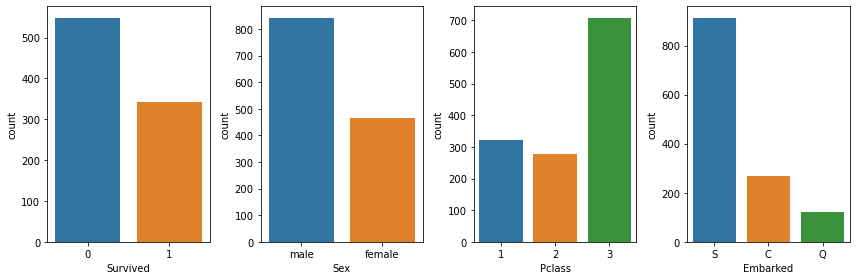

In [21]:
fig, ax = plt.subplots(1,4, figsize = (12,4))

sns.countplot(train['Survived'], ax=ax[0]);
sns.countplot(all_data['Sex'], ax=ax[1]);
sns.countplot(all_data['Pclass'], ax=ax[2]);
sns.countplot(all_data['Embarked'], ax=ax[3]);

plt.tight_layout()
plt.show()

we have a breakdown of each variable

In [32]:
gender_survived_rate = all_data.groupby('Sex')['Survived'].mean()
Pclass_survived_rate = all_data.groupby('Pclass')['Survived'].mean()
embarked_survived_rate = all_data.groupby('Embarked')['Survived'].mean()

gender_survived_rate

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

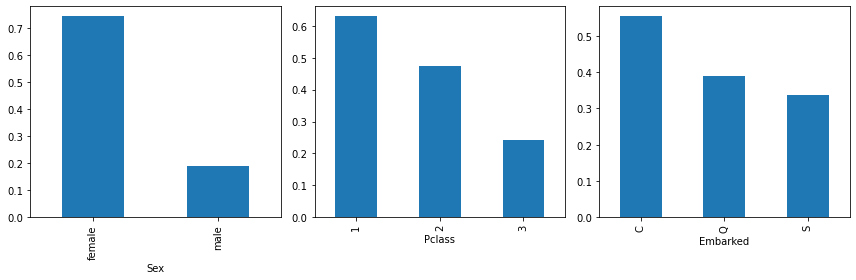

In [30]:
fig, ax = plt.subplots(1,3, figsize = (12,4))

gender_survived_rate.plot(kind = 'bar', ax=ax[0]);
Pclass_survived_rate.plot(kind = 'bar', ax=ax[1]);
embarked_survived_rate.plot(kind = 'bar', ax=ax[2]);

plt.tight_layout()
plt.show()

we can see the survival rates based on different features

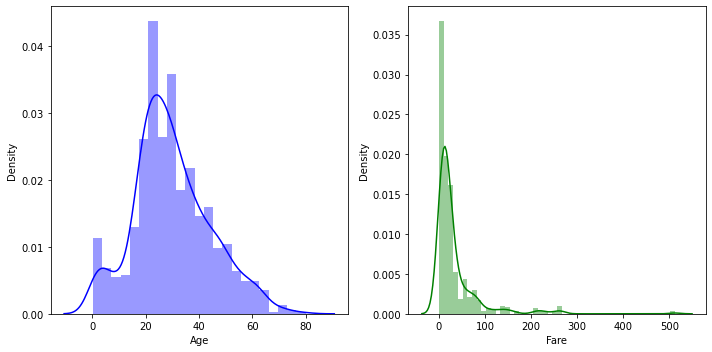

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

sns.distplot(all_data['Age'], ax=ax[0], color='blue');
sns.distplot(all_data['Fare'], ax=ax[1], color='green');

plt.tight_layout()
plt.show()

age looks well distributed, fare is skewed 

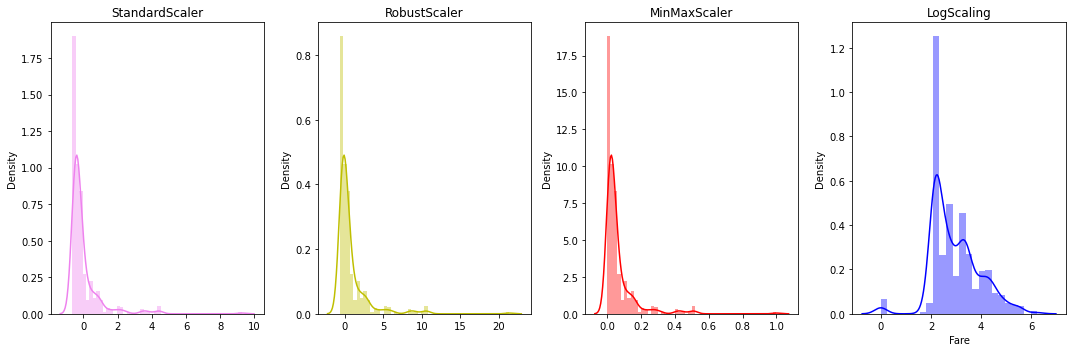

In [36]:
ss = StandardScaler()
rb = RobustScaler()
mm = MinMaxScaler()

fare_standard = ss.fit_transform(all_data['Fare'].values.reshape(-1, 1))
fare_robust = rb.fit_transform(all_data['Fare'].values.reshape(-1, 1))
fare_minmax = mm.fit_transform(all_data['Fare'].values.reshape(-1, 1))

fig, ax = plt.subplots(1, 4, figsize=(15, 5))

sns.distplot(fare_standard, color='violet', ax = ax[0]).set_title('StandardScaler');
sns.distplot(fare_robust, color='y', ax = ax[1]).set_title('RobustScaler');
sns.distplot(fare_minmax, color='r', ax = ax[2]).set_title('MinMaxScaler');
sns.distplot(np.log1p(train['Fare']), color='b', ax = ax[3]).set_title('LogScaling');

plt.tight_layout()
plt.show()

log scaling minimizes the skew best amongst these methods

In [37]:
all_data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

we have a handful of missing values in our data

In [38]:
all_data['missing_counts'] = all_data[all_data.columns[2:]].isna().sum(axis = 1)
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_counts
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,2
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,2


we can add a column to quantify the number of missing values per passenger

In [39]:
miss_one_hot = all_data[['Age', 'Cabin', 'Fare', 'Embarked']].isna()
miss_one_hot.columns = ['Age_miss', 'Cabin_miss', 'Fare_miss', 'Embarked_miss']
miss_one_hot

,Age_miss,Cabin_miss,Fare_miss,Embarked_miss
0,False,True,False,False
1,False,False,False,False
2,False,True,False,False
3,False,False,False,False
4,False,True,False,False
...,...,...,...,...
1304,True,True,False,False
1305,False,False,False,False
1306,False,True,False,False
1307,True,True,False,False


In [40]:
all_data = pd.concat([all_data, miss_one_hot], axis = 1)
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_counts,Age_miss,Cabin_miss,Fare_miss,Embarked_miss
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,False,True,False,False
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,False,False,False,False
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,False,True,False,False
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,False,False,False,False
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,2,True,True,False,False
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0,False,False,False,False
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,False,True,False,False
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,2,True,True,False,False


we have essentially turned the absence of a feature (i.e., a feature value missing) into a feature

In [41]:
all_data['Cabin'] = all_data['Cabin'].fillna('nan')
all_data['Embarked'] = all_data['Embarked'].fillna('nan')

le = LabelEncoder()

all_data['Cabin'] = le.fit_transform(all_data['Cabin'])
all_data['Sex'] = le.fit_transform(all_data['Sex'])
all_data['Embarked'] = le.fit_transform(all_data['Embarked'])
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_counts,Age_miss,Cabin_miss,Fare_miss,Embarked_miss
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,186,2,1,False,True,False,False
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,106,0,0,False,False,False,False
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,186,2,1,False,True,False,False
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,70,2,0,False,False,False,False
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,186,2,1,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",1,NaN,0,0,A.5. 3236,8.0500,186,2,2,True,True,False,False
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,64,0,0,False,False,False,False
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,186,2,1,False,True,False,False
1307,1308,NaN,3,"Ware, Mr. Frederick",1,NaN,0,0,359309,8.0500,186,2,2,True,True,False,False


*We can use ML to fill in missing values*

this step turns string values into numbers, allowing the algorithm to handle them. 
we can also fill all empty values with "NaN"

In [42]:
columns = list(all_data.columns)
columns.remove('PassengerId')
columns.remove('Survived')
columns.remove('Ticket')
columns.remove('Name')
columns

['Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Cabin',
 'Embarked',
 'missing_counts',
 'Age_miss',
 'Cabin_miss',
 'Fare_miss',
 'Embarked_miss']

we wish to except these columns from knnImputer

In [43]:
knn = KNNImputer()

imputed_data = all_data[columns]
imputed_data = knn.fit_transform(imputed_data)
imputed_data

array([[ 3. ,  1. , 22. , ...,  1. ,  0. ,  0. ],
       [ 1. ,  0. , 38. , ...,  0. ,  0. ,  0. ],
       [ 3. ,  0. , 26. , ...,  1. ,  0. ,  0. ],
       ...,
       [ 3. ,  1. , 38.5, ...,  1. ,  0. ,  0. ],
       [ 3. ,  1. , 24.5, ...,  1. ,  0. ,  0. ],
       [ 3. ,  1. , 22.8, ...,  1. ,  0. ,  0. ]])

In [44]:
all_data.iloc[:, 5] = imputed_data[:, 2]
all_data.iloc[:, 9] = imputed_data[:, 5]
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_counts,Age_miss,Cabin_miss,Fare_miss,Embarked_miss
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,186,2,1,False,True,False,False
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,106,0,0,False,False,False,False
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,186,2,1,False,True,False,False
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,70,2,0,False,False,False,False
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,186,2,1,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",1,24.5,0,0,A.5. 3236,8.0500,186,2,2,True,True,False,False
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,64,0,0,False,False,False,False
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,186,2,1,False,True,False,False
1307,1308,NaN,3,"Ware, Mr. Frederick",1,24.5,0,0,359309,8.0500,186,2,2,True,True,False,False


*we have now used ML to fill in missing values from some of our columns*

In [45]:
all_data.isna().sum()

PassengerId         0
Survived          418
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin               0
Embarked            0
missing_counts      0
Age_miss            0
Cabin_miss          0
Fare_miss           0
Embarked_miss       0
dtype: int64

In [46]:
name=[]
for i in range(len(all_data['Name'])):
    name.append(all_data['Name'].iloc[i].split(',')[1].split('.')[0])
all_data['Name']=name
all_data['Name']=all_data['Name'].replace([' Dr',' Mlle',' Rev',' Major',' Col',' Don',' the Countess',' Lady',' Jonkheer',' Sir',' Mme',' Ms',' Capt',' Dona'],'Rare')
all_data['Name']=all_data['Name'].replace({' Mr':1,' Miss':2,' Mrs':2,' Master':3,'Rare':4})

name=[]
for i in range(len(test['Name'])):
    name.append(test['Name'].iloc[i].split(',')[1].split('.')[0])
test['Name']=name
test['Name']=test['Name'].replace([' Dr',' Mlle',' Rev',' Major',' Col',' Don',' the Countess',' Lady',' Jonkheer',' Sir',' Mme',' Ms',' Capt',' Dona'],'Rare')
test['Name']=test['Name'].replace({' Mr':1,' Miss':2,' Mrs':2,' Master':3,'Rare':4})

In [47]:
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_counts,Age_miss,Cabin_miss,Fare_miss,Embarked_miss
0,1,0.0,3,1,1,22.0,1,0,A/5 21171,7.2500,186,2,1,False,True,False,False
1,2,1.0,1,2,0,38.0,1,0,PC 17599,71.2833,106,0,0,False,False,False,False
2,3,1.0,3,2,0,26.0,0,0,STON/O2. 3101282,7.9250,186,2,1,False,True,False,False
3,4,1.0,1,2,0,35.0,1,0,113803,53.1000,70,2,0,False,False,False,False
4,5,0.0,3,1,1,35.0,0,0,373450,8.0500,186,2,1,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,1,1,24.5,0,0,A.5. 3236,8.0500,186,2,2,True,True,False,False
1305,1306,NaN,1,4,0,39.0,0,0,PC 17758,108.9000,64,0,0,False,False,False,False
1306,1307,NaN,3,1,1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,186,2,1,False,True,False,False
1307,1308,NaN,3,1,1,24.5,0,0,359309,8.0500,186,2,2,True,True,False,False


In [54]:
ticket_split = all_data['Ticket'].apply(lambda x : x.split(' '))

ticket_2 = ticket_split[ticket_split.agg(len) == 2]

ticket_2_index = ticket_split[ticket_split.agg(len) == 2].index

ticket_code_2 = []

for i in ticket_2.index:
    ticket_code_2.append(ticket_2[i][0])
    
ticket_code_2_labeled = le.fit_transform(ticket_code_2)
ticket_code_2_labeled += 1

ticket_3 = ticket_split[ticket_split.agg(len) == 3]

ticket_3_index = ticket_split[ticket_split.agg(len) == 3].index

ticket_code_3 = []

for i in ticket_3.index:
    ticket_code_3.append(ticket_3[i][0])
ticket_code_3_labeled = le.fit_transform(ticket_code_3)
ticket_code_3_labeled += ticket_code_2_labeled.max()

We need to make the ticket values more suited for analysis

In [71]:
all_data['ticket_code'] = 0
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_counts,Age_miss,Cabin_miss,Fare_miss,Embarked_miss,ticket_code
0,1,0.0,3,1,1,22.0,1,0,A/5 21171,7.2500,186,2,1,False,True,False,False,0
1,2,1.0,1,2,0,38.0,1,0,PC 17599,71.2833,106,0,0,False,False,False,False,0
2,3,1.0,3,2,0,26.0,0,0,STON/O2. 3101282,7.9250,186,2,1,False,True,False,False,0
3,4,1.0,1,2,0,35.0,1,0,113803,53.1000,70,2,0,False,False,False,False,0
4,5,0.0,3,1,1,35.0,0,0,373450,8.0500,186,2,1,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,1,1,24.5,0,0,A.5. 3236,8.0500,186,2,2,True,True,False,False,0
1305,1306,NaN,1,4,0,39.0,0,0,PC 17758,108.9000,64,0,0,False,False,False,False,0
1306,1307,NaN,3,1,1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,186,2,1,False,True,False,False,0
1307,1308,NaN,3,1,1,24.5,0,0,359309,8.0500,186,2,2,True,True,False,False,0


In [56]:
all_data.loc[ticket_2_index, 'ticket_code'] = list(ticket_code_2_labeled)
all_data.loc[ticket_3_index, 'ticket_code'] = list(ticket_code_3_labeled)
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_counts,Age_miss,Cabin_miss,Fare_miss,Embarked_miss,ticket_code
0,1,0.0,3,1,1,22.0,1,0,A/5 21171,7.2500,186,2,1,False,True,False,False,5
1,2,1.0,1,2,0,38.0,1,0,PC 17599,71.2833,106,0,0,False,False,False,False,21
2,3,1.0,3,2,0,26.0,0,0,STON/O2. 3101282,7.9250,186,2,1,False,True,False,False,41
3,4,1.0,1,2,0,35.0,1,0,113803,53.1000,70,2,0,False,False,False,False,0
4,5,0.0,3,1,1,35.0,0,0,373450,8.0500,186,2,1,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,1,1,24.5,0,0,A.5. 3236,8.0500,186,2,2,True,True,False,False,2
1305,1306,NaN,1,4,0,39.0,0,0,PC 17758,108.9000,64,0,0,False,False,False,False,21
1306,1307,NaN,3,1,1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,186,2,1,False,True,False,False,38
1307,1308,NaN,3,1,1,24.5,0,0,359309,8.0500,186,2,2,True,True,False,False,0


ticket code allows for numerical representation of tickets. algorithm can now find trends in these numbers

In [57]:
all_data2 = all_data.drop(columns = ['Ticket', 'Survived', 'PassengerId'])
all_data2

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,missing_counts,Age_miss,Cabin_miss,Fare_miss,Embarked_miss,ticket_code
0,3,1,1,22.0,1,0,7.2500,186,2,1,False,True,False,False,5
1,1,2,0,38.0,1,0,71.2833,106,0,0,False,False,False,False,21
2,3,2,0,26.0,0,0,7.9250,186,2,1,False,True,False,False,41
3,1,2,0,35.0,1,0,53.1000,70,2,0,False,False,False,False,0
4,3,1,1,35.0,0,0,8.0500,186,2,1,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,1,1,24.5,0,0,8.0500,186,2,2,True,True,False,False,2
1305,1,4,0,39.0,0,0,108.9000,64,0,0,False,False,False,False,21
1306,3,1,1,38.5,0,0,7.2500,186,2,1,False,True,False,False,38
1307,3,1,1,24.5,0,0,8.0500,186,2,2,True,True,False,False,0


In [58]:
all_data2['Fare'] = np.log1p(all_data2['Fare'])

# modeling

In [59]:
train2 = all_data2[:len(train)]
test2 = all_data2[len(train):].reset_index(drop = True)

In [60]:
x_train, x_valid, y_train, y_valid = train_test_split(train2, train['Survived'], test_size = 0.2, random_state = 42, stratify = train['Survived'])

In [68]:
cat = CatBoostClassifier(verbose = 1000,
                         eval_metric='Accuracy',
                         early_stopping_rounds=1000,
                         n_estimators=10000,
                         learning_rate = 0.025,
                         max_depth=7)

cat.fit(x_train, y_train, eval_set=[(x_valid, y_valid)])

result = cat.predict(test2)

gender_submission['Survived'] = result

gender_submission.to_csv('gender_submission_catboost.csv', index = 0)

0:	learn: 0.8078541	test: 0.8483146	best: 0.8483146 (0)	total: 3.48ms	remaining: 34.8s
1000:	learn: 0.9733520	test: 0.8539326	best: 0.8539326 (727)	total: 1.08s	remaining: 9.74s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8539325843
bestIteration = 727

Shrink model to first 728 iterations.


In [63]:
stk = StratifiedKFold(n_splits=5, random_state = 42, shuffle = True)

result_cat = 0

for fold, (train_index, valid_index) in enumerate(stk.split(train2, train['Survived'])):
    x_train, y_train = train2.iloc[train_index], train['Survived'][train_index]
    x_valid, y_valid = train2.iloc[valid_index], train['Survived'][valid_index]
    
    cat = CatBoostClassifier(verbose = 1000,
                         eval_metric='Accuracy',
                         early_stopping_rounds=1000,
                         n_estimators=10000,
                         learning_rate = 0.02,
                         max_depth=8)
    print('----------Fold', fold+1, 'Start!--------')
    cat.fit(x_train, y_train, eval_set=[(x_valid, y_valid)])
    print('----------Fold', fold+1, 'Done!--------')
    result_cat += cat.predict_proba(test2)[:, 1] / 5

print('Done')

----------Fold 1 Start!--------
0:	learn: 0.8216292	test: 0.8268156	best: 0.8268156 (0)	total: 2.25ms	remaining: 22.5s
1000:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (507)	total: 1.39s	remaining: 12.5s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8715083799
bestIteration = 507

Shrink model to first 508 iterations.
----------Fold 1 Done!--------
----------Fold 2 Start!--------
0:	learn: 0.8330996	test: 0.8089888	best: 0.8089888 (0)	total: 1.84ms	remaining: 18.4s
1000:	learn: 0.9845722	test: 0.8314607	best: 0.8539326 (556)	total: 1.32s	remaining: 11.9s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8539325843
bestIteration = 556

Shrink model to first 557 iterations.
----------Fold 2 Done!--------
----------Fold 3 Start!--------
0:	learn: 0.8288920	test: 0.7696629	best: 0.7696629 (0)	total: 2.13ms	remaining: 21.3s
1000:	learn: 0.9803647	test: 0.7921348	best: 0.8314607 (25)	total: 1.37s	remaining: 12.3s
Stopped by overfitting detect

In [65]:
gender_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


In [69]:
gender_submission['Survived'] = result_cat
gender_submission['Survived'] = gender_submission['Survived'].astype(np.int64)
gender_submission.to_csv('submission_stratifiedkfold.csv', index = 0)

done